In [1]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import os.path
import time, itertools, re
from sklearn.metrics import make_scorer
import miceforest as mf
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split,StratifiedGroupKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.mixture import GaussianMixture
import matplotlib.patches as patches
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy.linalg import norm
from sklearn import metrics
from sklearn.decomposition import FactorAnalysis, PCA
print(os.getcwd())
fileloc_data='/'.join(os.getcwd().split('/')[0:5])+ '/data/annonymizedDatasets/'
savetag='combo_lavSQ_MHC'
print(fileloc_data)
#sys.path.append('/'.join(os.getcwd().split('/')[0:4])+'/nan_smote/')
from FigPlotting import clusterPlot, plot_dendrogram
save_model_path_name='pickles/'
import pickle
date='20250205'
cluster_model_fname="%sEDprofiling_Clusters_%s.pkl"%(save_model_path_name,date)
#cluster_model_fname="%sEDprofiling_Clusters.pkl"%(save_model_path_name)
#if os.path.exists(cluster_model_fname):
#    models_clustering = pickle.load(open(cluster_model_fname, "rb"))
#    print('Loading final Clustering models complete')
#else:
models_clustering={}
from EDdataset_GGZ import colsTypeCast    
#df_adapted_combo=pd.read_csv(fileloc_data+'maskedDAIsy_MainED_Lav_SQ48_MHCSF_Visit1.tsv', sep='\t', decimal=',')
#df_adapted_combo, colsExtracted_adapted, subscales_adapted=colsTypeCast(df_adapted_combo)
full_linked_data_fname='%smaskedDAIsy_MainED_Lav_SQ48_MHCSF_Visit1.tsv'%(fileloc_data)
df_Question_EDEQ=pd.read_csv(full_linked_data_fname, sep='\t', decimal=',')
name_mapping=pd.read_csv('/'.join(os.getcwd().split('/')[0:5])+ '/data/Map_1.csv', sep=',')
df_adapted_combo, colsExtracted, subscales=colsTypeCast(df_Question_EDEQ)
all_vitals=pd.read_csv('/'.join(os.getcwd().split('/')[0:5])+'/data/annonymizedDatasets/maskedDAIsy_Vitals.csv', sep='\t')
bmi_from_vitals=all_vitals[['intid','O_METING', 'WAARDE1','WAARDE2']].loc[\
        (all_vitals['intid'].astype(int).isin(df_adapted_combo['intid'].astype(int))) & \
        (all_vitals['O_METING']=='Body Mass Index')]
print(bmi_from_vitals.shape, bmi_from_vitals['intid'].nunique(), df_adapted_combo['intid'].nunique())
bmi_from_vitals.to_csv('/'.join(os.getcwd().split('/')[0:5])+'/data/annonymizedDatasets/maskedDAIsy_BMI.csv', sep='\t')
#print(df_adapted_combo.shape[0]-df_adapted_combo['DT-BMI'].isnull().sum())
#print(bmi_from_vitals.h)
print(colsExtracted)

/home/sreejita/anaconda3/envs/py_env1/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


/home/sreejita/ProjectsPy/GGZ/code_scripts/ED-profiling
/home/sreejita/ProjectsPy/GGZ/data/annonymizedDatasets/
(7140, 4) 243 309
['Main-Age', 'Main-Biosex', 'Main-Education', 'ED_Codes', 'EDEQ-Score', 'Lav-Negative_appraisal_body', 'Lav-Unfamiliarity_with_body', 'Lav-Dissatisfaction_body', 'Lav-Score', 'MHCSF-Emotional_Well-being', 'MHCSF-Social_Well-being', 'MHCSF-Psychological_Well-being', 'MHCSF-Score', 'SQ48-Hostility', 'SQ48-Agoraphobia', 'SQ48-Anxiety', 'SQ48-Depression', 'SQ48-Cognitive_Complaints', 'SQ48-Somatic_Complaints', 'SQ48-Social_phobia', 'SQ48-Vitality', 'SQ48-Work_related_complaints', 'SQ48-Score']


In [2]:
substrings=['Age', 'Education','Biosex', 'SQ48', 'MHCSF','Lav']
cols2train=['Main-Age','Main-Biosex','Main-Education']+\
                subscales['Lav']+subscales['SQ48']+subscales['MHCSF']
all_scores=['intid','EDEQ-Score',  'Lav-Score', 'SQ48-Score', 'MHCSF-Score', 'Split']
cols2train=list(np.setdiff1d(cols2train, all_scores))
df_cluster=df_adapted_combo[cols2train+['Split']].copy()
cols2train_renamed, show_col_names={},[]
for sub in substrings:
    res = [i for i in cols2train if sub in i]
    cols2train_renamed[sub]=res
df_cluster.rename(columns=cols2train_renamed, inplace=True)    

for idx, col in enumerate(cols2train):
    if col in name_mapping['Current'].to_list():
        col=name_mapping['Updated'].loc[name_mapping['Current']==col].to_list()[0]
        show_col_names.append(col)
    else:            
        if (col.split('-')[0]=='Main') | (col=='DT-BMI'):
            col=col.split('-')[1]   
        show_col_names.append(' '.join(col.split('_')))
ticklab_dic=dict(zip(cols2train, show_col_names))
df_cluster.rename(columns=ticklab_dic, inplace=True)
cols2train=np.setdiff1d(df_cluster.columns,['Split'])
print(df_cluster.columns)
df_train, df_test=df_cluster.loc[df_cluster['Split']=='Train'].copy(), df_cluster.loc[df_cluster['Split']=='Test'].copy()
labs_train=df_adapted_combo['EDtype'].loc[df_adapted_combo['Split']=='Train'].copy()
labs_test=df_adapted_combo['EDtype'].loc[df_adapted_combo['Split']=='Test'].copy()

Index(['Lav-Dissatisfaction body', 'Lav-Negative appraisal body',
       'Lav-Unfamiliarity with body', 'MHCSF-Emotional Well-being',
       'MHCSF-Psychological Well-being', 'MHCSF-Social Well-being', 'Age',
       'Biosex', 'Education', 'SQ48-Agoraphobia', 'SQ48-Anxiety',
       'SQ48-Cognitive Complaints', 'SQ48-Depression', 'SQ48-Hostility',
       'SQ48-Social phobia', 'SQ48-Somatic Complaints', 'SQ48-Vitality',
       'SQ48-Work related complaints', 'Split'],
      dtype='object')


In [3]:
nan_mean=np.nanmean(df_train[cols2train].to_numpy(), axis=0)
nan_std=np.nanstd(df_train[cols2train].to_numpy(), axis=0)
z_train_nan=((df_train[cols2train].to_numpy()-nan_mean)/nan_std)
z_train_df=pd.DataFrame(data=z_train_nan, columns=cols2train)
z_test_df=pd.DataFrame(data=((df_test[cols2train].to_numpy()-nan_mean)/nan_std), columns=cols2train)
pca_adapted = PCA(svd_solver='full').fit(z_train_df)
pca_z_train, pca_z_test=pca_adapted.transform(z_train_df), pca_adapted.transform(z_test_df)
variance_explained_adapt=np.cumsum(pca_adapted.explained_variance_)*100/np.sum(pca_adapted.explained_variance_)
comp_adapt= pca_adapted.components_
fa_adapted = FactorAnalysis(n_components=len(cols2train), random_state=0)
fa_z_train, fa_z_test= fa_adapted.fit_transform(z_train_df), fa_adapted.fit_transform(z_test_df)
m, noise = fa_adapted.components_, fa_adapted.noise_variance_

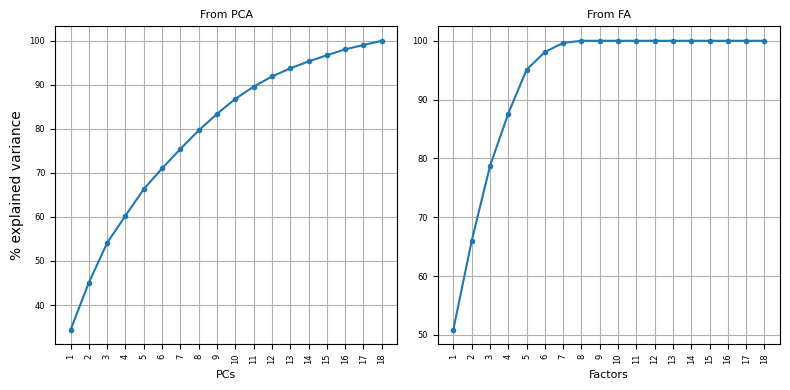

In [4]:
var_expl_fa, m2 = np.zeros(len(cols2train),), np.sum(m**2,axis=1)
for idx in range(0,len(cols2train)):
    var_expl_fa[idx]=(100*m2[idx])/(np.sum(m2)+np.sum(noise))

fs=8
fig,(a1,a2)=plt.subplots(1,2,figsize=(8, 4))# Create a scree plot to visualize the explained variance
a1.plot(range(1, len(variance_explained_adapt) + 1), # x-axis
         variance_explained_adapt, # convert explained variance in percentage
         marker='o',markersize=3)
# Add title and axis label
a1.set_xticks(range(1, len(variance_explained_adapt) + 1))
a1.set_xticklabels(a1.get_xticklabels(), fontsize=fs-2, rotation=90)
a1.set_yticklabels(a1.get_yticklabels(), fontsize=fs-2)
#a1.set_title('Explained variance from PCA', fontsize=fs)
a1.set_xlabel('PCs', fontsize=fs)
a1.set_ylabel('% explained variance')
a1.grid()
# Add title and axis label
a1.set_title('From PCA', fontsize=fs)
a1.set_xlabel('PCs', fontsize=fs)
a2.plot(range(1, len(var_expl_fa) + 1), np.cumsum(var_expl_fa/sum(var_expl_fa))*100,marker='o',markersize=3)
a2.set_xticks(range(1, len(var_expl_fa) + 1))
a2.set_xticklabels(a2.get_xticklabels(), fontsize=fs-2, rotation=90)
a2.set_yticklabels(a2.get_yticklabels(), fontsize=fs-2)
a2.set_title('From FA', fontsize=fs)
a2.set_xlabel('Factors', fontsize=fs)
a2.grid()
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_PCA_FA_woBMI.pdf'%savetag, bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/ED_%s_PCA_FA_woBMI.png'%savetag, bbox_inches='tight', dpi=200)

Exists!
Optimal number of clusters=4 and components=5 based on silhoette coeff value
4
Estimated number of clusters: 4
Homogeneity: 0.046
Completeness: 0.057
V-measure: 0.051
Adjusted Rand Index: 0.022
Adjusted Mutual Information: 0.033
Silhouette Coefficient: 0.185


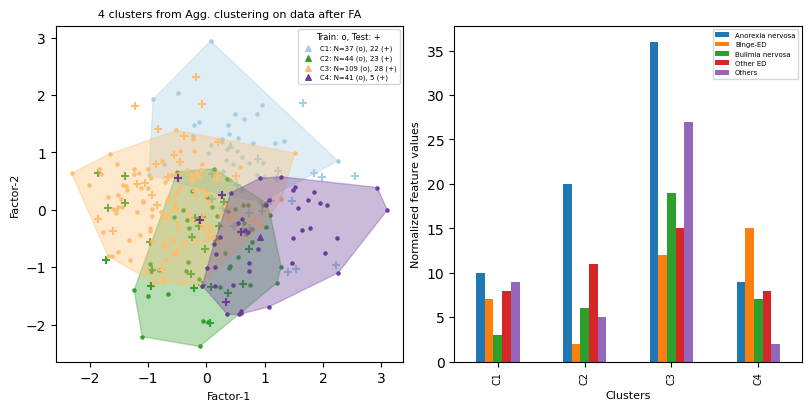

In [5]:
from sklearn.cluster import AgglomerativeClustering
from numpy import unravel_index
save_model_path_name='pickles/'
random_seed = 101
random.seed(random_seed)
df_train_, df_test_=df_train.copy(), df_test.copy()
df_train_['EDtype'], df_test_['EDtype']=labs_train, labs_test
z_train_df['EDtype']=df_train_['EDtype']
z_train_df['EDEQ-Score']=df_adapted_combo['EDtype'].loc[df_adapted_combo['Split']=='Train'].copy()#fa_ndim=5
#linkage, diss, metric, iters='complete', 'precomputed', 'cosine',
linkage, diss, metric, iters='complete', 'cosine', 'cosine',7
#linkage, diss, metric, iters='complete', 'euclidean', 'euclidean',9
#linkage, diss, metric, iters='ward', 'euclidean', 'euclidean',9
#data_to_cluster=fa_z_train[:,:fa_ndim]
#test_data_to_cluster=fa_z_test[:,:fa_ndim]
#linkage, diss='ward', 'euclidean'
if os.path.exists(cluster_model_fname):
    print('Exists!')
    models_clustering = pickle.load(open(cluster_model_fname, "rb"))
    cluster_model=models_clustering['AggFA_%s'%date]
    agg_fa_clust, train_aggfa_labs, test_aggfa_labs=cluster_model['model'],cluster_model['train_pred_labs'], cluster_model['test_pred_labs']
    ncomp, nclust_aggfa=cluster_model['ncomp'], cluster_model['nclust']
    data_to_cluster=pairwise_distances(fa_z_train[:,:ncomp], metric=metric)
    test_data_to_cluster=pairwise_distances(fa_z_test[:,:ncomp], metric=metric)
    print('Optimal number of clusters=%d and components=%d based on silhoette coeff value'%( nclust_aggfa, ncomp))
else:        
    ncomp_opts, nclust_opts=list(range(4,8)), list(range(4,9))
    sill_coef, nC=np.zeros((iters,len(nclust_opts), len(ncomp_opts))),[]
    for jdx, nclust in enumerate(nclust_opts):        
        for idx,n_comp in enumerate(ncomp_opts):
            data_to_cluster_trial=fa_z_train[:,:n_comp]#pairwise_distances(fa_z_train[:,:n_comp], metric=metric)
            #data_to_cluster_trial=pairwise_distances(fa_z_train[:,:n_comp], metric=metric)            
            for iter in range(0,iters): 
                try_agg_clust=AgglomerativeClustering(n_clusters=nclust, linkage=linkage).fit(data_to_cluster_trial)
                sill_coef[iter, jdx, idx]=metrics.silhouette_score(data_to_cluster_trial,try_agg_clust.fit_predict(data_to_cluster_trial), 
                                                                   metric=diss) 
        nClustComp=np.mean(sill_coef,axis=0)             
    jdx, idx=unravel_index(nClustComp.argmax(), nClustComp.shape)
    #data_to_cluster=pairwise_distances(fa_z_train[:,:ncomp_opts[idx]], metric=metric)
    #test_data_to_cluster=pairwise_distances(fa_z_test[:,:ncomp_opts[idx]], metric=metric)
    data_to_cluster=fa_z_train[:,:ncomp_opts[idx]]
    test_data_to_cluster=fa_z_test[:,:ncomp_opts[idx]]
    agg_fa_clust=AgglomerativeClustering(n_clusters=nclust_opts[jdx], linkage=linkage).fit(data_to_cluster)
    train_aggfa_labs=agg_fa_clust.fit_predict(data_to_cluster)
    test_aggfa_labs=agg_fa_clust.fit_predict(test_data_to_cluster)
    nclust_aggfa, ncomp=nclust_opts[jdx], ncomp_opts[idx]#len(np.unique(agg_fa_labels))
    print('Optimal number of clusters=%d and components=%d based on silhoette coeff value'%( nclust_opts[jdx], ncomp_opts[idx]))
    cluster_model={'model': agg_fa_clust, 'name': 'Agglomerative', 'train_pred_labs': train_aggfa_labs,
                   'test_pred_labs': test_aggfa_labs, 'ncomp':ncomp_opts[idx], 'nclust': nclust_opts[jdx], 'metric':metric}
    
print(len(np.unique(test_aggfa_labs)))
data_tabs={'data_to_cluster': data_to_cluster, 'data_to_plot': fa_z_train,'df': df_train_,'z_df': z_train_df, 'cols2train': cols2train,
           'test_data_to_cluster': test_data_to_cluster,'test_data_to_plot': fa_z_test}
fig_naming=['AggFA_%s'%date, savetag, 'AggFA']
fig_lab_titles={'fig_title': 'clusters from Agg. clustering on data after FA', 'ncols':1,
               'fs': 8, 'legend_loc': 'upper right', 'ax0_xlab':'Factor-1', 'ax0_ylab':'Factor-2'}

print("Estimated number of clusters: %d" %nclust_aggfa)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labs_train, train_aggfa_labs))
print("Completeness: %0.3f" % metrics.completeness_score(labs_train, train_aggfa_labs))
print("V-measure: %0.3f" % metrics.v_measure_score(labs_train, train_aggfa_labs))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labs_train, train_aggfa_labs))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labs_train, train_aggfa_labs))
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(data_to_cluster, train_aggfa_labs, metric=diss))

zs_fa_agg_ed_cluster_df, ed_fa_agg_df, colors=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)
df_cluster_train=df_adapted_combo[['intid','EDtype', 'EDEQ-Score']].loc[df_adapted_combo['Split']=='Train'].copy()
df_cluster_test=df_adapted_combo[['intid','EDtype', 'EDEQ-Score']].loc[df_adapted_combo['Split']=='Test'].copy()
zs_fa_agg_ed_cluster_df.rename(columns=ticklab_dic, inplace=True)
models_clustering[fig_naming[0]]=cluster_model
 

(4, 4)


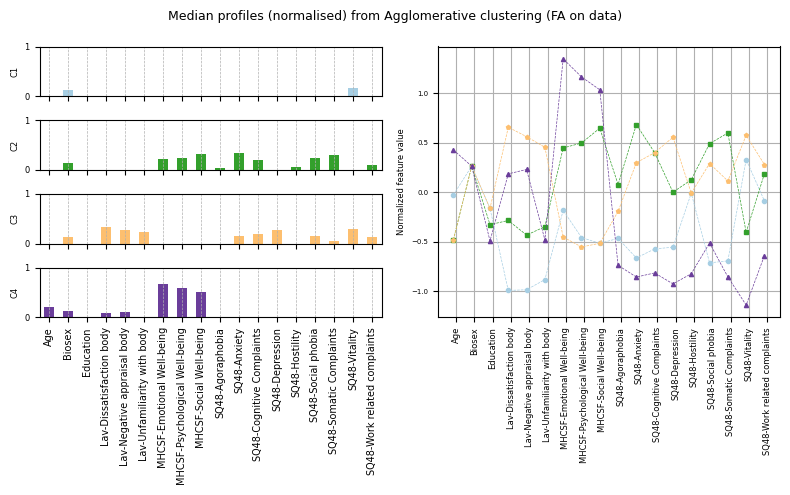

<Figure size 400x300 with 0 Axes>

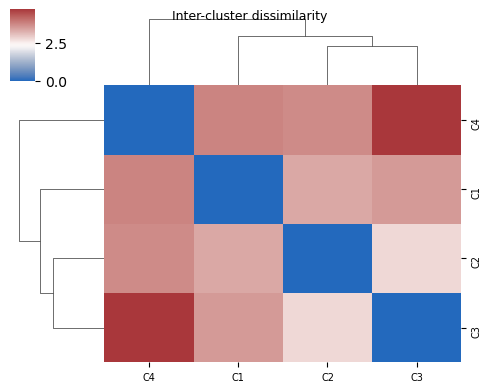

In [6]:
#if ~os.path.exists(cluster_model_fname):
#    with open('%s'%cluster_model_fname, 'wb') as f:  # open a text file
#            pickle.dump(models_clustering, f)
fig21=plt.figure(figsize=(8,5), constrained_layout=True)
marker_shapes=['o','s','p','^','v','D','H','*','>','<','P']
prof_colnames=zs_fa_agg_ed_cluster_df.columns
df_cluster_train[fig_naming[0]], df_cluster_test[fig_naming[0]]=np.nan, np.nan
for nrow, col in zip(range(nclust_aggfa), colors):
    ax21=plt.subplot(nclust_aggfa,2,2*nrow+1)
    df_temp=zs_fa_agg_ed_cluster_df.iloc[nrow]
    df_cluster_train[fig_naming[0]].iloc[np.where(train_aggfa_labs==nrow)[0]]='C'+str(nrow+1)
    df_cluster_test[fig_naming[0]].iloc[np.where(test_aggfa_labs==nrow)[0]]='C'+str(nrow+1)
    df_temp.plot.bar(legend=False, color=col['color'], rot=90, ax=ax21)
    ax21.set_ylim(0, 2)
    ax21.set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax21.set_yticklabels(ax21.get_yticklabels(), fontsize=6)
    if nrow<nclust_aggfa-1:        
        ax21.set_xticklabels('')
    else:
        ax21.set_xticklabels(prof_colnames, fontsize=7)    
    ax21.grid(axis='x', linestyle = '--', linewidth = 0.5)
ax21=plt.subplot(1,2,2)
for nrow, col in zip(range(nclust_aggfa), colors):
    df_temp=zs_fa_agg_ed_cluster_df.iloc[nrow]
    df_temp.plot(marker=marker_shapes[nrow], ax=ax21, color=col['color'], linewidth=0.5,linestyle='--',markersize=3)

ax21.set_xticks(np.arange(len(prof_colnames))+0.15, labels=prof_colnames, rotation=90)
ax21.set_xticklabels(ax21.get_xticklabels(), fontsize=6, rotation=90)
ax21.set_yticklabels(ax21.get_yticklabels(), fontsize=5)
ax21.set_ylabel('Normalized feature value', fontsize=fs-2)
ax21.grid()

fig21.suptitle('Median profiles (normalised) from Agglomerative clustering (FA on data)', fontsize=9)
plt.tight_layout()
plt.savefig('figs/PDFs/clustering/ED_%s_Profiles.pdf'%fig_naming[0],bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/clustering/ED_%s_Profiles.png'%fig_naming[0],bbox_inches='tight', dpi=200)

fig22= plt.figure(figsize=(4,3))
pw_sqeuclid=pairwise_distances(zs_fa_agg_ed_cluster_df.to_numpy(), metric='euclidean')
print(np.shape(pw_sqeuclid))
fig22=sns.clustermap(pw_sqeuclid, cmap='vlag', figsize=(5,4), method='complete')#,col_cluster=['C%d'+str(x+1) for x in range(0,evd_n_clusters_)])
fig22.fig.suptitle('Inter-cluster dissimilarity', fontsize=9)
ticklabs=[]
for lab in fig22.ax_heatmap.axes.get_xticklabels():
    ticklabs.append('C%d'%(int(lab.get_text())+1))    
fig22.ax_heatmap.axes.set_xticklabels(ticklabs, fontsize=7)
fig22.ax_heatmap.axes.set_yticklabels(ticklabs, fontsize=7)
#fig32.tight_layout()
fig22.savefig('figs/PDFs/clustering/ED_%s_Clustermap_Proximity.pdf'%fig_naming[0], bbox_inches='tight', dpi=200)
fig22.savefig('figs/PNGs/clustering/ED_%s_Clustermap_Proximity.png'%fig_naming[0], bbox_inches='tight', dpi=200)



Exists!
Optimal number of clusters=4 and components=15 based on silhoette coeff value
4
Estimated number of clusters: 4
Homogeneity: 0.028
Completeness: 0.041
V-measure: 0.033
Adjusted Rand Index: 0.003
Adjusted Mutual Information: 0.012
Silhouette Coefficient: 0.246


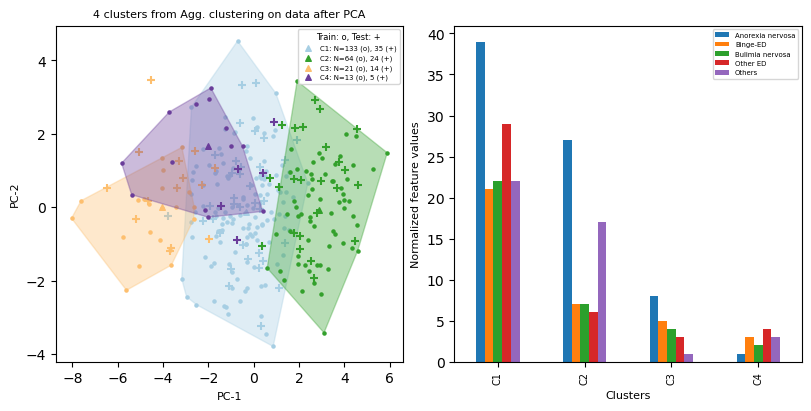

In [7]:
random_seed,iters =5,11
random.seed(random_seed)
#linkage, diss, metric='complete', 'cosine', 'cosine'
#linkage, diss, metric='complete', 'euclidean', 'euclidean'
linkage, diss, metric='ward', 'euclidean', 'euclidean'
if os.path.exists(cluster_model_fname):
    print('Exists!')
    cluster_model=models_clustering['AggPCA_%s'%date]
    agg_pca_clust, train_aggpca_labs, test_aggpca_labs=cluster_model['model'],cluster_model['train_pred_labs'], cluster_model['test_pred_labs']
    ncomp, nclust_aggpca=cluster_model['ncomp'], cluster_model['nclust']
    data_to_cluster=pairwise_distances(pca_z_train[:,:ncomp], metric=metric)
    test_data_to_cluster=pairwise_distances(pca_z_test[:,:ncomp], metric=metric)
    print('Optimal number of clusters=%d and components=%d based on silhoette coeff value'%( nclust_aggpca, ncomp))
else:        
    ncomp_opts, nclust_opts=list(range(9,18)), list(range(4,10))
    sill_coef, nC=np.zeros((iters,len(nclust_opts), len(ncomp_opts))),[]
    for jdx, nclust in enumerate(nclust_opts):        
        for idx,n_comp in enumerate(ncomp_opts):
            #data_to_cluster_trial=pairwise_distances(pca_z_train[:,:n_comp], metric=metric)            
            data_to_cluster_trial=pca_z_train[:,:n_comp]
            for iter in range(0,5): 
                try_agg_clust=AgglomerativeClustering(n_clusters=nclust, linkage=linkage).fit(data_to_cluster_trial)
                sill_coef[iter, jdx, idx]=metrics.silhouette_score(data_to_cluster_trial,try_agg_clust.fit_predict(data_to_cluster_trial), metric=diss) 
        nClustComp=np.mean(sill_coef,axis=0)             
    jdx, idx=unravel_index(nClustComp.argmax(), nClustComp.shape)
    #data_to_cluster=pairwise_distances(pca_z_train[:,:ncomp_opts[idx]], metric=metric)
    #test_data_to_cluster=pairwise_distances(pca_z_test[:,:ncomp_opts[idx]], metric=metric)
    data_to_cluster=pca_z_train[:,:ncomp_opts[idx]]
    test_data_to_cluster=pca_z_test[:,:ncomp_opts[idx]]
    agg_pca_clust=AgglomerativeClustering(n_clusters=nclust_opts[jdx], linkage=linkage).fit(data_to_cluster)
    train_aggpca_labs=agg_pca_clust.fit_predict(data_to_cluster)
    test_aggpca_labs=agg_pca_clust.fit_predict(test_data_to_cluster)
    nclust_aggpca, ncomp=nclust_opts[jdx], ncomp_opts[idx]#len(np.unique(agg_fa_labels))
    print('Optimal number of clusters=%d and components based on silhoette coeff value=%d'%(nclust_opts[jdx],ncomp_opts[idx]))
    cluster_model={'model': agg_pca_clust, 'name': 'Agglomerative', 'train_pred_labs': train_aggpca_labs,
                   'test_pred_labs': test_aggpca_labs, 'ncomp':ncomp_opts[idx], 'nclust': nclust_opts[jdx], 'metric':metric}    
print(len(np.unique(test_aggpca_labs)))
data_tabs={'data_to_cluster': data_to_cluster, 'data_to_plot': pca_z_train,'df': df_train_,'z_df': z_train_df, 'cols2train': cols2train,
           'test_data_to_cluster': test_data_to_cluster,'test_data_to_plot': pca_z_test}
fig_naming=['AggPCA_%s'%date, savetag]
fig_lab_titles={'fig_title': 'clusters from Agg. clustering on data after PCA', 'ncols':1,
               'fs': 8, 'legend_loc': 'upper right', 'ax0_xlab':'PC-1', 'ax0_ylab':'PC-2'}

print("Estimated number of clusters: %d" %nclust_aggpca)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labs_train, train_aggpca_labs))
print("Completeness: %0.3f" % metrics.completeness_score(labs_train, train_aggpca_labs))
print("V-measure: %0.3f" % metrics.v_measure_score(labs_train, train_aggpca_labs))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labs_train, train_aggpca_labs))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labs_train, train_aggpca_labs))
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(data_to_cluster, train_aggpca_labs, metric=diss))
zs_pca_agg_ed_cluster_df, ed_pca_agg_df, colors=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)
zs_pca_agg_ed_cluster_df.rename(columns=ticklab_dic, inplace=True)
models_clustering[fig_naming[0]]=cluster_model

(4, 4)


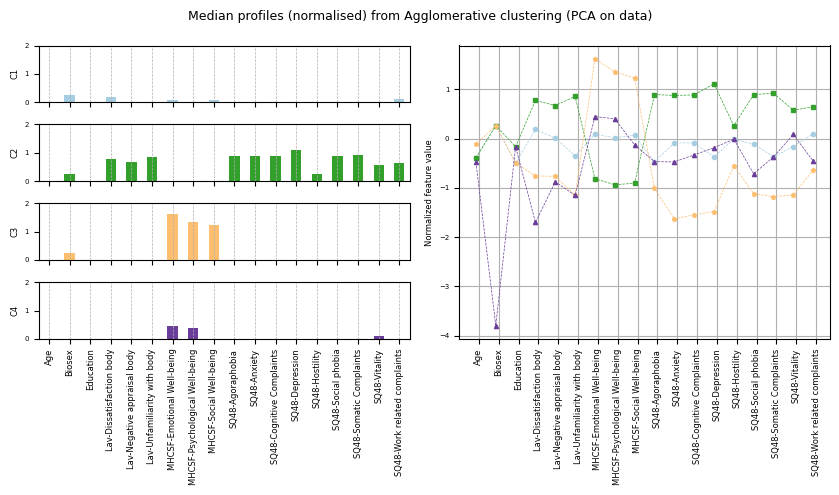

<Figure size 400x300 with 0 Axes>

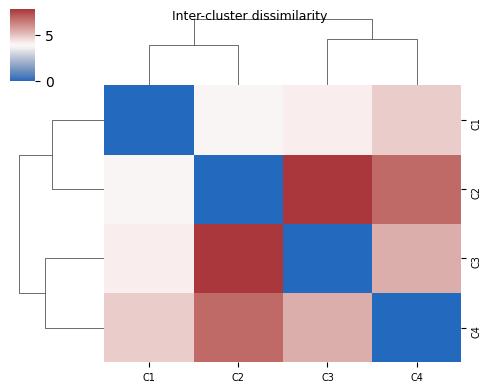

In [8]:
fig31=plt.figure(figsize=(8.5,5), constrained_layout=True)
marker_shapes=['o','s','p','^','v','D','H','*','>','<','P']
prof_colnames=zs_pca_agg_ed_cluster_df.columns
df_cluster_train[fig_naming[0]], df_cluster_test[fig_naming[0]]=np.nan, np.nan
for nrow, col in zip(range(nclust_aggpca), colors):
    ax31=plt.subplot(nclust_aggpca,2,2*nrow+1)
    df_temp=zs_pca_agg_ed_cluster_df.iloc[nrow]
    df_cluster_train[fig_naming[0]].iloc[np.where(train_aggpca_labs==nrow)[0]]='C'+str(nrow+1)
    df_cluster_test[fig_naming[0]].iloc[np.where(test_aggpca_labs==nrow)[0]]='C'+str(nrow+1)
    df_temp.plot.bar(legend=False, color=col['color'], rot=90, ax=ax31)
    ax31.set_ylim(0, 2)
    ax31.set_ylabel('C%d'%(nrow+1), fontsize=6)    
    if nrow<nclust_aggpca-1:        
        ax31.set_xticklabels('')
    else:
        ax31.set_xticklabels(prof_colnames, fontsize=6)  
    ax31.set_yticklabels(ax31.get_yticklabels(), fontsize=5)
    ax31.grid(axis='x', linestyle = '--', linewidth = 0.5)
ax32=plt.subplot(1,2,2)
for nrow, col in zip(range(nclust_aggpca), colors):
    df_temp=zs_pca_agg_ed_cluster_df.iloc[nrow]
    df_temp.plot(marker=marker_shapes[nrow], ax=ax32, color=col['color'], linewidth=0.5,linestyle='--',
                markersize=3)
ax32.set_xticks(np.arange(len(prof_colnames))+0.15, labels=prof_colnames, rotation=90)
ax32.set_xticklabels(ax32.get_xticklabels(), fontsize=6, rotation=90)
ax32.set_yticklabels(ax32.get_yticklabels(), fontsize=5)
ax32.set_ylabel('Normalized feature value', fontsize=fs-2)
ax32.grid()

fig31.suptitle('Median profiles (normalised) from Agglomerative clustering (PCA on data)', fontsize=9)
plt.tight_layout()
plt.savefig('figs/PDFs/clustering/ED_%s_Profiles.pdf'%fig_naming[0],bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/clustering/ED_%s_Profiles.png'%fig_naming[0],bbox_inches='tight', dpi=200)

fig32= plt.figure(figsize=(4,3))
pw_sqeuclid=pairwise_distances(zs_pca_agg_ed_cluster_df.to_numpy(), metric='euclidean')
print(np.shape(pw_sqeuclid))
fig32=sns.clustermap(pw_sqeuclid, cmap='vlag', figsize=(5,4), method='complete')
fig32.fig.suptitle('Inter-cluster dissimilarity', fontsize=9)
ticklabs=[]
for lab in fig32.ax_heatmap.axes.get_xticklabels():
    ticklabs.append('C%d'%(int(lab.get_text())+1))    
fig32.ax_heatmap.axes.set_xticklabels(ticklabs, fontsize=7)
fig32.ax_heatmap.axes.set_yticklabels(ticklabs, fontsize=7)
fig32.savefig('figs/PDFs/clustering/ED_%s_Clustermap_Proximity.pdf'%fig_naming[0], bbox_inches='tight', dpi=200)
fig32.savefig('figs/PNGs/clustering/ED_%s_Clustermap_Proximity.png'%fig_naming[0], bbox_inches='tight', dpi=200)

Exists!
Optimal number of clusters=5 and components=13 based on silhoette coeff value
Estimated number of clusters: 5
Homogeneity: 0.046
Completeness: 0.049
V-measure: 0.048
Adjusted Rand Index: 0.029
Adjusted Mutual Information: 0.024
Silhouette Coefficient: 0.204


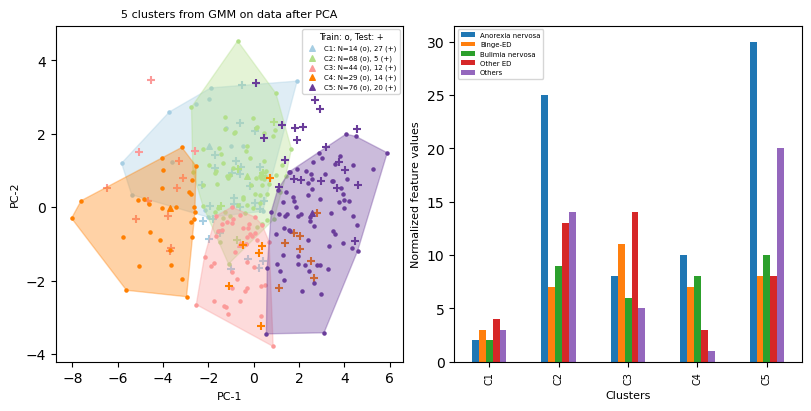

In [9]:
random_seed,iters= 101,5
random.seed(random_seed)
#linkage, diss, metric='ward', 'euclidean', 'euclidean'
#linkage, diss, metric='complete', 'euclidean', 'euclidean'
linkage, diss, metric='complete', 'cosine', 'cosine'
if os.path.exists(cluster_model_fname):
    print('Exists!')
    cluster_model=models_clustering['GMMPCA_%s'%date]
    gmm_pca_clust, train_gmmpca_labs, test_gmmpca_labs=cluster_model['model'],cluster_model['train_pred_labs'], cluster_model['test_pred_labs']
    ncomp, nclust_gmmpca=cluster_model['ncomp'], cluster_model['nclust']
    data_to_cluster=pca_z_train[:,:ncomp]
    test_data_to_cluster=pca_z_test[:,:ncomp]
    print('Optimal number of clusters=%d and components=%d based on silhoette coeff value'%(nclust_gmmpca, ncomp))
else:        
    ncomp_opts, nclust_opts=list(range(9,18)), list(range(4,10))
    sill_coef, nC=np.zeros((iters,len(nclust_opts), len(ncomp_opts))),[]
    for jdx, nclust in enumerate(nclust_opts):        
        for idx,n_comp in enumerate(ncomp_opts):
            data_to_cluster_trial=pca_z_train[:,:n_comp]
            for iter in range(0,5): 
                try_gmm_clust=GaussianMixture(n_init=5, max_iter=300, n_components=nclust, covariance_type='spherical',
                            init_params='random_from_data').fit(data_to_cluster_trial)
                sill_coef[iter, jdx, idx]=metrics.silhouette_score(data_to_cluster_trial,try_gmm_clust.fit_predict(data_to_cluster_trial), metric=diss) 
        nClustComp=np.mean(sill_coef,axis=0)             
    jdx, idx=unravel_index(nClustComp.argmax(), nClustComp.shape)
    data_to_cluster=pca_z_train[:,:ncomp_opts[idx]]
    test_data_to_cluster=pca_z_test[:,:ncomp_opts[idx]]
    gmm_pca_clust=GaussianMixture(n_init=5, max_iter=300, n_components=nclust_opts[jdx], covariance_type='spherical',
                            init_params='random_from_data').fit(data_to_cluster)
    train_gmmpca_labs=gmm_pca_clust.fit_predict(data_to_cluster)
    test_gmmpca_labs=gmm_pca_clust.fit_predict(test_data_to_cluster)
    nclust_gmmpca, ncomp=nclust_opts[jdx], ncomp_opts[idx]#len(np.unique(agg_fa_labels))
    print('Optimal number of clusters=%d and components based on silhoette coeff value=%d'%(nclust_opts[jdx],ncomp_opts[idx]))    
    cluster_model={'model': gmm_pca_clust, 'name': 'GMM', 'train_pred_labs': train_gmmpca_labs,
                   'test_pred_labs': test_gmmpca_labs, 'ncomp':ncomp_opts[idx], 'nclust': nclust_opts[jdx], 'metric':metric}
data_tabs={'data_to_cluster': data_to_cluster, 'data_to_plot': pca_z_train,'df': df_train_,'z_df': z_train_df, 'cols2train': cols2train,
           'test_data_to_cluster': test_data_to_cluster,'test_data_to_plot': pca_z_test}
fig_naming=['GMMPCA_%s'%date, savetag, 'GMMPCA']
fig_lab_titles={'fig_title': 'clusters from GMM on data after PCA', 'ncols':1,
               'fs': 8, 'legend_loc': 'upper right', 'ax0_xlab':'PC-1', 'ax0_ylab':'PC-2'}

print("Estimated number of clusters: %d" %nclust_gmmpca)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labs_train, train_gmmpca_labs))
print("Completeness: %0.3f" % metrics.completeness_score(labs_train, train_gmmpca_labs))
print("V-measure: %0.3f" % metrics.v_measure_score(labs_train, train_gmmpca_labs))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labs_train, train_gmmpca_labs))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labs_train, train_gmmpca_labs))
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(data_to_cluster, train_gmmpca_labs, metric=diss))
zs_pca_gmm_ed_cluster_df, ed_pca_gmm_df, colors=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)
zs_pca_gmm_ed_cluster_df.rename(columns=ticklab_dic, inplace=True)
models_clustering[fig_naming[0]]=cluster_model

(5, 5)


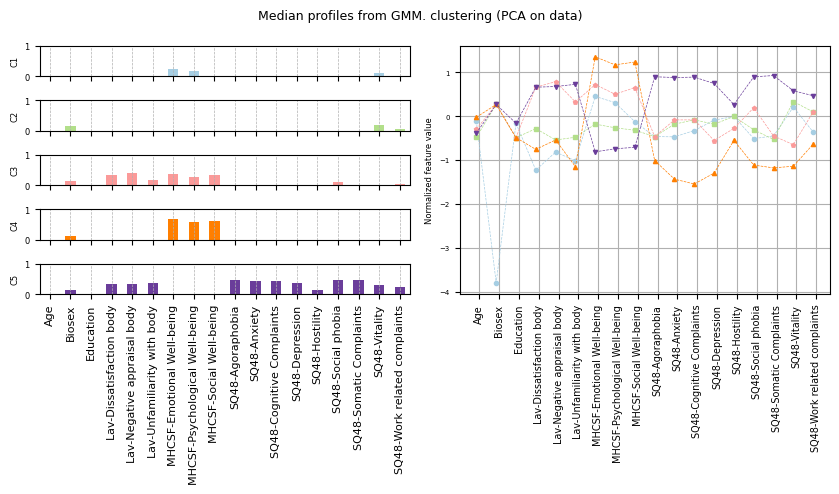

<Figure size 400x300 with 0 Axes>

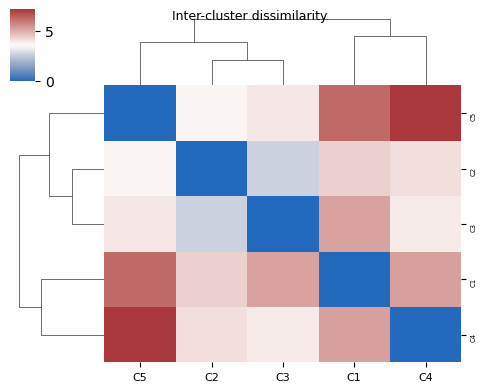

In [10]:
fig41 = plt.figure(figsize=(8.5,5), constrained_layout=True)
colnames=zs_pca_gmm_ed_cluster_df.columns#np.setdiff1d(gmm_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])
df_cluster_train[fig_naming[0]], df_cluster_test[fig_naming[0]]=np.nan, np.nan
for nrow, col in zip(range(nclust_gmmpca), colors):
    ax41=plt.subplot(nclust_gmmpca,2,2*nrow+1)
    df_temp=zs_pca_gmm_ed_cluster_df[colnames].iloc[nrow]
    df_cluster_train[fig_naming[0]].iloc[np.where(train_gmmpca_labs==nrow)[0]]='C'+str(nrow+1)
    df_cluster_test[fig_naming[0]].iloc[np.where(test_gmmpca_labs==nrow)[0]]='C'+str(nrow+1)
    df_temp.plot.bar(legend=False, color=col['color'], rot=90, ax=ax41)
    ax41.set_ylim(0, 2)
    ax41.set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax41.set_yticklabels(ax41.get_yticklabels(), fontsize=6)
    if nrow<nclust_gmmpca-1:        
        ax41.set_xticklabels('')
    else:
        ax41.set_xticklabels(colnames, fontsize=8)    
    ax41.grid(axis='x', linestyle = '--', linewidth = 0.5)

ax42=plt.subplot(1,2,2)
for nrow, col in zip(range(nclust_gmmpca), colors):
    df_temp=zs_pca_gmm_ed_cluster_df.iloc[nrow]
    df_temp.plot(marker=marker_shapes[nrow], ax=ax42, color=col['color'], linewidth=0.5,linestyle='--',
                markersize=3)
fig41.suptitle('Median profiles from GMM. clustering (PCA on data)', fontsize=9)
ax42.set_xticks(np.arange(len(colnames))+0.15, labels=colnames, rotation=90)
ax42.set_xticklabels(ax42.get_xticklabels(), fontsize=7, rotation=90)
ax42.set_yticklabels(ax42.get_yticklabels(), fontsize=5, rotation=0)
ax42.set_ylabel('Normalized feature value', fontsize=fs-2)
ax42.grid()
plt.tight_layout()
plt.savefig('figs/PDFs/clustering/ED_%s_Profiles.pdf'%fig_naming[0], bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/clustering/ED_%s_Profiles.png'%fig_naming[0], bbox_inches='tight', dpi=200)



fig42= plt.figure(figsize=(4,3))
pw_sqeuclid=pairwise_distances(zs_pca_gmm_ed_cluster_df.to_numpy(), metric='euclidean')
print(np.shape(pw_sqeuclid))
fig42=sns.clustermap(pw_sqeuclid, cmap='vlag', figsize=(5,4), method='complete')#,col_cluster=['C%d'+str(x+1) for x in range(0,evd_n_clusters_)])
fig42.fig.suptitle('Inter-cluster dissimilarity', fontsize=9)
ticklabs=[]
for lab in fig42.ax_heatmap.axes.get_xticklabels():
    ticklabs.append('C%d'%(int(lab.get_text())+1))    
fig42.ax_heatmap.axes.set_xticklabels(ticklabs, fontsize=8)
fig42.ax_heatmap.axes.set_yticklabels(ticklabs, fontsize=5)
fig42.savefig('figs/PDFs/clustering/ED_%s_Clustermap_Proximity.pdf'%fig_naming[0], bbox_inches='tight', dpi=200)
fig42.savefig('figs/PNGs/clustering/ED_%s_Clustermap_Proximity.png'%fig_naming[0], bbox_inches='tight', dpi=200)

Exists!
Optimal number of clusters=4 and components=5 based on silhoette coeff value
Estimated number of clusters: 4
Homogeneity: 0.048
Completeness: 0.060
V-measure: 0.054
Adjusted Rand Index: 0.021
Adjusted Mutual Information: 0.035
Silhouette Coefficient: 0.227


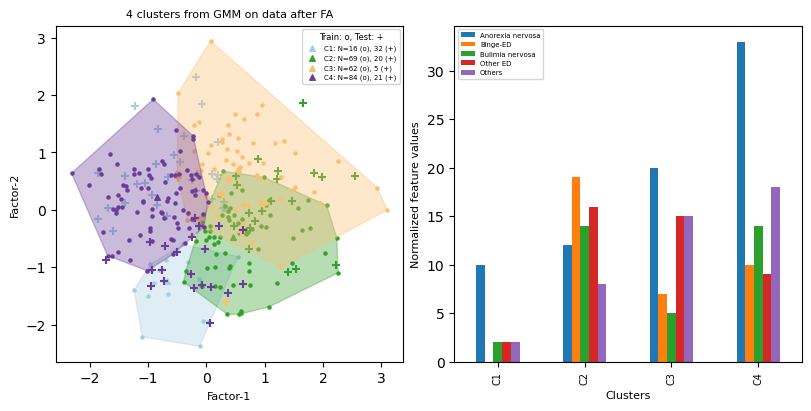

In [11]:
random_seed,iters= 10,5
random.seed(random_seed)
#diss, metric= 'euclidean', 'euclidean'
diss, metric='cosine', 'cosine'
if os.path.exists(cluster_model_fname):
    print('Exists!')
    cluster_model=models_clustering['GMMFA_%s'%date]
    gmm_fa_clust, train_gmmfa_labs, test_gmmfa_labs=cluster_model['model'],cluster_model['train_pred_labs'], cluster_model['test_pred_labs']
    ncomp, nclust_gmmfa=cluster_model['ncomp'], cluster_model['nclust']
    data_to_cluster=fa_z_train[:,:ncomp]
    test_data_to_cluster=fa_z_test[:,:ncomp]
    print('Optimal number of clusters=%d and components=%d based on silhoette coeff value'%( nclust_gmmfa, ncomp))
else:        
    ncomp_opts, nclust_opts=list(range(4,8)), list(range(4,10))
    sill_coef, nC=np.zeros((iters,len(nclust_opts), len(ncomp_opts))),[]
    for jdx, nclust in enumerate(nclust_opts):        
        for idx,n_comp in enumerate(ncomp_opts):
            data_to_cluster_trial=fa_z_train[:,:n_comp]
            for iter in range(0,5): 
                try_gmm_clust=GaussianMixture(n_init=5, max_iter=500, n_components=nclust, covariance_type='spherical',
                            init_params='k-means++').fit(data_to_cluster_trial)
                sill_coef[iter, jdx, idx]=metrics.silhouette_score(data_to_cluster_trial,try_gmm_clust.fit_predict(data_to_cluster_trial), metric=diss) 
        nClustComp=np.mean(sill_coef,axis=0)             
    jdx, idx=unravel_index(nClustComp.argmax(), nClustComp.shape)
    data_to_cluster=fa_z_train[:,:ncomp_opts[idx]]
    test_data_to_cluster=fa_z_test[:,:ncomp_opts[idx]]
    gmm_fa_clust=GaussianMixture(n_init=5, max_iter=500, n_components=nclust_opts[jdx], covariance_type='spherical',
                            init_params='k-means++').fit(data_to_cluster)
    train_gmmfa_labs=gmm_fa_clust.fit_predict(data_to_cluster)
    test_gmmfa_labs=gmm_fa_clust.fit_predict(test_data_to_cluster)
    nclust_gmmfa, ncomp=nclust_opts[jdx], ncomp_opts[idx]#len(np.unique(agg_fa_labels))
    print('Optimal number of clusters=%d and components based on silhoette coeff value=%d'%(nclust_opts[jdx],ncomp_opts[idx]))    
    cluster_model={'model': gmm_fa_clust, 'name': 'GMM', 'train_pred_labs': train_gmmfa_labs,
                   'test_pred_labs': test_gmmfa_labs, 'ncomp':ncomp_opts[idx], 'nclust': nclust_opts[jdx], 'metric':metric}
data_tabs={'data_to_cluster': data_to_cluster, 'data_to_plot': fa_z_train,'df': df_train_,'z_df': z_train_df, 'cols2train': cols2train,
           'test_data_to_cluster': test_data_to_cluster,'test_data_to_plot': fa_z_test}
fig_naming=['GMMFA_%s'%date, savetag, 'GMMFA']
fig_lab_titles={'fig_title': 'clusters from GMM on data after FA', 'ncols':1,
               'fs': 8, 'legend_loc': 'upper right', 'ax0_xlab':'Factor-1', 'ax0_ylab':'Factor-2'}

print("Estimated number of clusters: %d" %nclust_gmmfa)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labs_train, train_gmmfa_labs))
print("Completeness: %0.3f" % metrics.completeness_score(labs_train, train_gmmfa_labs))
print("V-measure: %0.3f" % metrics.v_measure_score(labs_train, train_gmmfa_labs))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labs_train, train_gmmfa_labs))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labs_train, train_gmmfa_labs))
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(data_to_cluster, train_gmmfa_labs, metric=diss))
zs_fa_gmm_ed_cluster_df, ed_fa_gmm_df, colors=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)
zs_fa_gmm_ed_cluster_df.rename(columns=ticklab_dic, inplace=True)
models_clustering[fig_naming[0]]=cluster_model

(4, 4)


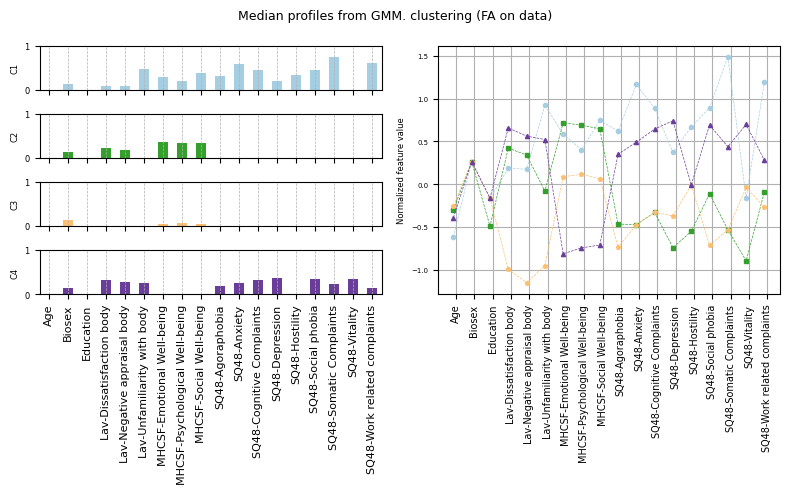

<Figure size 400x300 with 0 Axes>

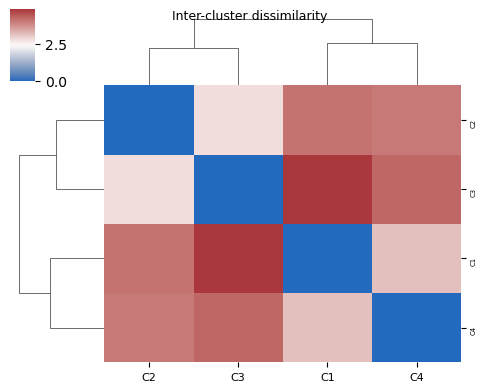

In [12]:
fig51 = plt.figure(figsize=(8,5), constrained_layout=True)
colnames=zs_fa_gmm_ed_cluster_df.columns#np.setdiff1d(gmm_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])
df_cluster_train[fig_naming[0]], df_cluster_test[fig_naming[0]]=np.nan, np.nan
for nrow, col in zip(range(nclust_gmmfa), colors):
    ax51=plt.subplot(nclust_gmmfa,2,2*nrow+1)
    df_temp=zs_fa_gmm_ed_cluster_df[colnames].iloc[nrow]
    df_cluster_train[fig_naming[0]].iloc[np.where(train_gmmfa_labs==nrow)[0]]='C'+str(nrow+1)
    df_cluster_test[fig_naming[0]].iloc[np.where(test_gmmfa_labs==nrow)[0]]='C'+str(nrow+1)
    df_temp.plot.bar(legend=False, color=col['color'], rot=90, ax=ax51)
    ax51.set_ylim(0, 2)
    ax51.set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax51.set_yticklabels(ax51.get_yticklabels(), fontsize=6)
    if nrow<nclust_gmmfa-1:        
        ax51.set_xticklabels('')
    else:
        ax51.set_xticklabels(colnames, fontsize=8)    
    ax51.grid(axis='x', linestyle = '--', linewidth = 0.5)
ax52=plt.subplot(1,2,2)
for nrow, col in zip(range(nclust_gmmfa), colors):
    df_temp=zs_fa_gmm_ed_cluster_df.iloc[nrow]
    df_temp.plot(marker=marker_shapes[nrow], ax=ax52, color=col['color'], linewidth=0.5,linestyle='--',
                markersize=3)
ax52.set_xticks(np.arange(len(colnames))+0.15, labels=colnames, rotation=90)
ax52.set_xticklabels(ax52.get_xticklabels(), fontsize=7, rotation=90)
ax52.set_yticklabels(ax52.get_yticklabels(), fontsize=5, rotation=0)
ax52.set_ylabel('Normalized feature value', fontsize=fs-2)
ax52.grid()
fig51.suptitle('Median profiles from GMM. clustering (FA on data)', fontsize=9)
plt.tight_layout()
plt.savefig('figs/PDFs/clustering/ED_%s_Profiles.pdf'%fig_naming[0], bbox_inches='tight', dpi=200)
plt.savefig('figs/PNGs/clustering/ED_%s_Profiles.png'%fig_naming[0], bbox_inches='tight', dpi=200)


fig52= plt.figure(figsize=(4,3))
pw_sqeuclid=pairwise_distances(zs_fa_gmm_ed_cluster_df.to_numpy(), metric='euclidean')
print(np.shape(pw_sqeuclid))
fig52=sns.clustermap(pw_sqeuclid, cmap='vlag', figsize=(5,4), method='complete')#,col_cluster=['C%d'+str(x+1) for x in range(0,evd_n_clusters_)])
fig52.fig.suptitle('Inter-cluster dissimilarity', fontsize=9)
ticklabs=[]
for lab in fig52.ax_heatmap.axes.get_xticklabels():
    ticklabs.append('C%d'%(int(lab.get_text())+1))    
fig52.ax_heatmap.axes.set_xticklabels(ticklabs, fontsize=8)
fig52.ax_heatmap.axes.set_yticklabels(ticklabs, fontsize=5)
fig52.savefig('figs/PDFs/clustering/ED_%s_Clustermap_Proximity.pdf'%fig_naming[0], bbox_inches='tight', dpi=200)
fig52.savefig('figs/PNGs/clustering/ED_%s_Clustermap_Proximity.png'%fig_naming[0], bbox_inches='tight', dpi=200)

In [13]:
if ~os.path.exists(cluster_model_fname):
    with open('%s'%cluster_model_fname, 'wb') as f:  # open a text file
            pickle.dump(models_clustering, f)

df_cluster_test_safe=df_cluster_test.copy()
df_cluster_train_safe=df_cluster_train.copy()
full_linked_data_dec='%s/maskedDAIsy_MainDec_EDEQ_SQ48_MHCSF_Honos_Lav_Visit_eg.tsv'%(fileloc_data)
df_decinfo=pd.read_csv(full_linked_data_dec, sep='\t', decimal=',')

In [14]:
df_cluster_test_safe['No. of previous treatments']=df_decinfo[['DT-num_prev_routes']].loc[
        df_decinfo['intid'].astype(float).isin(df_cluster_test['intid'].astype(float))].copy()
df_cluster_train_safe['No. of previous treatments']=df_decinfo[['DT-num_prev_routes']].loc[
        df_decinfo['intid'].astype(float).isin(df_cluster_train['intid'].astype(float))].copy()
df_cluster_test_safe['Split']='Test'
df_cluster_train_safe['Split']='Train'
#df_cluster.merge(df_DT_deets, on='intid', how='inner')
df_cluster_safe=pd.concat([df_cluster_train_safe, df_cluster_test_safe])
df_cluster_safe.to_csv('tabs/'+'EDcombined_ClusterMembership_20250205.csv', sep='\t',index=False)
df_cluster_safe

,intid,EDtype,EDEQ-Score,AggPCA_20250205,GMMPCA_20250205,GMMFA_20250205,No. of previous treatments,Split
1,1491.0,Binge-ED,4.76,C1,C3,C2,1.0,Train
2,1481.0,Anorexia nervosa,5.15,C2,C5,C4,5.0,Train
3,1613.0,Bulimia nervosa,5.95,C2,C5,C4,NaN,Train
4,1387.0,Other ED,1.48,C4,C1,C3,NaN,Train
5,1603.0,Other ED,3.89,C1,C5,C4,2.0,Train
...,...,...,...,...,...,...,...,...
296,1687.0,Other ED,2.51,C1,C1,C4,NaN,Test
302,1636.0,Other ED,1.58,C2,C5,C1,NaN,Test
304,1500.0,Bulimia nervosa,2.94,C1,C5,C1,NaN,Test
306,1301.0,Binge-ED,2.74,C3,C3,C2,NaN,Test
